# TP Python Master IBM/RPM
## 2ème partie : manipuler des images biomédicales à l'aide des bibliothèques `SimpleITK` et `pydicom`
Février 2025

### Albertine Dubois - <span class="glyphicon glyphicon-envelope"></span> albertine.dubois@cea.fr
----

*   <a href="#part1">Afficher et manipuler des images biomédicales</a>
*   <a href="#part2">Afficher et manipuler des images au format DICOM</a>
*   <a href="#part3">Lecture des en-têtes DICOM à l'aide de la librairie pydicom</a>

In [1]:
!git clone https://github.com/marsvn/PythonM2-jour2.git
!pip install SimpleITK

Cloning into 'PythonM2-jour2'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 70 (delta 34), reused 57 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 7.83 MiB | 9.97 MiB/s, done.
Resolving deltas: 100% (34/34), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 18.4 MB/s eta 0:00:00


Method 1: Add to Your Drive

    Go to Google Drive.
    Find the shared folder under "Shared with me."
    Right-click → "Add shortcut to Drive" → Place it inside "My Drive."
    Then access it via:

shared_folder_path = "/content/drive/My Drive/YourSharedFolderName"

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/data.zip -d /content


Archive:  /content/drive/MyDrive/data.zip
   creating: /content/data/
  inflating: /content/data/1-PT.nii  
  inflating: /content/data/2d-array.png  
  inflating: /content/data/3d-array-stack.png  
  inflating: /content/data/3d-array.png  
  inflating: /content/data/CT-Thorax.mhd  
  inflating: /content/data/CT-Thorax.raw  
  inflating: /content/data/CT.dcm    
  inflating: /content/data/CT.nii    
  inflating: /content/data/dicom2.png  
  inflating: /content/data/dicomstructure.jpg  
  inflating: /content/data/dicomstructure.png  
  inflating: /content/data/ImageOriginAndSpacing.png  
  inflating: /content/data/MRI.jpg   
   creating: /content/data/patient2/
  inflating: /content/data/patient2/Patient2.CT._.4.1.2019.11.21.11.52.34.596.71223801.dcm  
  inflating: /content/data/patient2/Patient2.CT._.4.10.2019.11.21.11.52.34.596.71223900.dcm  
  inflating: /content/data/patient2/Patient2.CT._.4.100.2019.11.21.11.52.34.596.71224890.dcm  
  inflating: /content/data/patient2/Patient2.CT._.

## <a name="part1"></a>1. Afficher et manipuler des images biomédicales
[ITK](https://itk.org/) ou Insight Segmentation and Registration Toolkit est un système multi-plateforme open-source offrant aux développeurs une suite complète d’outils logiciels pour l’analyse d’images.

Parmi elles, [SimpleITK](https://simpleitk.org/) est une couche simplifiée construite sur ITK, destinée à faciliter son utilisation dans les langages interprétés.

SimpleITK est une boîte à outils d’analyse d’images comprenant un grand nombre de composants prenant en charge les opérations de filtrage générales, la segmentation et l’enregistrement des images.

SimpleITK lui-même est écrit en C++ mais est disponible pour un grand nombre de langages de programmation, y compris Python.

### Conventions SimpleITK et rappels sur l'encodage des images
    
L'accès au contenu d'une image se fait selon un ordre `x,y,z` classique avec `image.GetPixel(x,y,z)` ou `image[x,y,z]`.

Les indices des images commencent à 0.

Par convention, SimpleITK, à l'instar d'ITK, considère que les images sont des objets physiques qui occupent une région close dans un espace physique. Ce concept est illustré par la figure suivante :

<figure>
<center>
<img src="https://github.com/marsvn/PythonM2-jour2/blob/main/data/ImageOriginAndSpacing.png?raw=1">
<!--img src="http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/ImageOriginAndSpacing.png" -->
</figure>

Le contenu de chaque pixel est encodé suivant un certain nombre de valeurs (ou niveaux) possibles, qui peuvent être positives, négatives, entières, décimales suivant la modalité d'imagerie considérée. Cet encodage caractérise ce qu'on appelle le **type** d'un pixel.

Le nombre de niveaux possibles est défini par la profondeur de l'encodage c’est-à-dire le nombre de bits utilisés pour encoder la valeur d'un pixel.

En imagerie médicale, la profondeur de l'encodage peut-être égale à :
* $1$ bit ($2^1=2$ niveaux)
* $2$ bits ($2^2=4$ niveaux)
* $4$ bits ($2^4=16$ niveaux)
* $5$ bits ($2^5=32$  niveaux)
* $8$ bits ($2^8=256$  niveaux)
* $16$ bits ($2^{16}=65536$ niveaux)
* $32$ bits ($2^{32}=4294967296$ niveaux)

<figure>
<center>
<img src="https://github.com/marsvn/PythonM2-jour2/blob/main/data/quantification_TPRX.png?raw=1">
</figure>
    
Voici la liste de types d'image que vous pourriez être amenés à rencontrer en médecine nucléaire. D'autres types existent bien sûr.

<table>
  <tr><td>Nomenclature SimpleITK</td><td>Description</td><td>Valeurs permises</td></tr>
  <tr><td>sitkUInt8</td><td>Unsigned 8 bit integer</td><td>0,1,2,...,255</td></tr>
  <tr><td>sitkUInt16</td><td>Unsigned 16 bit integer</td><td>0,1,2,...,65535</td></tr>
  <tr><td>sitkInt16</td><td>Signed 16 bit integer</td><td>-32768,...,0,...,32767</td></tr>
  <tr><td>sitkFloat32</td><td>32 bit float</td><td>-1.7976931348623157e+308,...,0,...,1.7976931348623157e+308</td></tr>
  <tr><td>sitkFloat64</td><td>64 bit float</td><td>-1.7976931348623157e+308,...,0,...,1.7976931348623157e+308</td></tr>
</table>

Au final, les composants suivants sont nécessaires pour définir complètement une image :
1. Le **type** de pixel [défini à la création, pas de valeur par défaut] : pour la liste complète voir au dessus.
2. Les **dimensions** [défini à la création, pas de valeur par défaut] : le nombre de pixels/voxels dans chaque direction. Cela définit les dimensions de l'image.
3. L'**origine** [par défaut 0] : coordonnées du pixel/voxel ayant l'indice (0,0,0) en unité physique (mm).
4. L'**espacement** [par défaut 1] : distance en mm séparant 2 pixels/voxels adjacents dans chaque dimension.
5. **Matrice des directions** [par défaut la matrice identité] : matrice liant les vecteurs directeurs de l'image et les axes des coordonnées physiques.

### 1.1 Accéder aux attributs d'une image SimpleITK

Importez le module `SimpleITK` pour pouvoir l'utiliser dans votre programme.

In [4]:
import SimpleITK as sitk

Pour ouvrir une image d'un fichier présent sur le disque, il existe une fonction ```ReadImage```.

In [5]:
# Lecture d'une image CT au format mhd
image_ct = sitk.ReadImage('./data/CT-Thorax.mhd') # Renvoie une image ou plus généralement un objet de type SimpleITK
type(image_ct)

SimpleITK.SimpleITK.Image

Il est ensuite très simple d'accèder aux principales informations de l'image.

#### 1.1.1 Origine, taille et résolution

In [6]:
print("Origine de l'image CT (en mm) :", image_ct.GetOrigin(),'\n')

print("Résolution de l'image CT (taille du voxel en mm) :",image_ct.GetSpacing(),'\n')

print("Taille de l'image CT (en nombre de pixels) :",image_ct.GetSize())
print("Nombre de lignes dans l'image CT :",image_ct.GetSize()[0])
print("Nombre de colonnes dans l'image CT :",image_ct.GetSize()[1])
print("Nombre de coupes/plans dans l'image CT :",image_ct.GetSize()[2],'\n')

print("Direction de l'image CT :",image_ct.GetDirection())

Origine de l'image CT (en mm) : (-173.68, -298.18, -259.3) 

Résolution de l'image CT (taille du voxel en mm) : (0.640625, 0.640625, 0.5) 

Taille de l'image CT (en nombre de pixels) : (512, 512, 831)
Nombre de lignes dans l'image CT : 512
Nombre de colonnes dans l'image CT : 512
Nombre de coupes/plans dans l'image CT : 831 

Direction de l'image CT : (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


#### 1.1.2 Dimensions

In [7]:
print("Dimension de l'image CT :",image_ct.GetDimension(),'\n')

print("Largeur de l'image CT (en nombre de pixels) :",image_ct.GetWidth())
print("Hauteur de l'image CT (en nombre de pixels) :",image_ct.GetHeight())
print("Profondeur de l'image CT (en nombre de pixels) :",image_ct.GetDepth())

Dimension de l'image CT : 3 

Largeur de l'image CT (en nombre de pixels) : 512
Hauteur de l'image CT (en nombre de pixels) : 512
Profondeur de l'image CT (en nombre de pixels) : 831


#### 1.1.3 Type des pixels

In [ ]:
print("Nombre d'octets (1 octet = 8 bits) sur lequel sont encodés les pixels de l'image CT :",image_ct.GetPixelIDValue())
print("Type des pixels de l'image CT :",image_ct.GetPixelIDTypeAsString())
print("Nombre de composantes par pixel de l'image CT :",image_ct.GetNumberOfComponentsPerPixel())

Nombre d'octets (1 octet = 8 bits) sur lequel sont encodés les pixels de l'image CT : 2
Type des pixels de l'image CT : 16-bit signed integer
Nombre de composantes par pixel de l'image CT : 1


#### 1.1.4 Affichage d'une image
La fonction `Show` permet d'afficher l'image passée en paramètre à la fonction. Par défaut, le système cherchera à utiliser le logiciel *[ImageJ](http://imagej.nih.gov/ij/)* présent sur votre système. Il est possible de changer ce comportement par défaut en assignant la variable d'environnement `SITK_SHOW_COMMAND` sur une autre application permettant de visualiser les images (*[ITK-SNAP](http://www.itksnap.org)*, *[3D Slicer](www.slicer.org)*).

In [8]:
import plotly.express as px
import SimpleITK as sitk

# Load Image
image_array = sitk.GetArrayFromImage(image_ct)

# Display Middle Slice
middle_slice = image_array[image_array.shape[0] // 2]
fig = px.imshow(middle_slice, color_continuous_scale='gray')
fig.update_layout(coloraxis_showscale=False)
fig.show()

In [ ]:
#%env SITK_SHOW_COMMAND "C:\Users\NEMO11\Desktop\Optionnel_Python_IA_2023\ITKSNAP\ITK-SNAP 3.8\bin\ITK-SNAP" #"C:\Program Files\Slicer 4.10.2\Slicer"
sitk.Show(image_ct)

RuntimeError: Exception thrown in SimpleITK Show: /tmp/SimpleITK/Code/IO/src/sitkImageViewer.cxx:755:
sitk::ERROR: No ImageJ/Fiji application found.

### 1.2 Convertir une image SimpleITK en un array NumPy

**<span style='color:red'>Attention, l'ordre d'accès aux indices d'une image SimpleITK et de la même image après conversion NumPy est inversé !</span>**

* SimpleITK : <code>image[x,y,z]</code> **colonnes - lignes - plans**
* NumPy : <code>image_numpy_array[z,y,x]</code> **plans - lignes - colonnes**

Pour une image 2D après conversion en un array NumPy 2D :
* Le premier indice, **i**, sélectionne la ligne
* Le deuxième indice, **j**, sélectionne la colonne

<center>
<img width =200 src="https://github.com/marsvn/PythonM2-jour2/blob/main/data/2d-array.png?raw=1">
</center>

Pour une image 3D après conversion en un array NumPy 3D :
* Le premier indice, **i**, sélectionne le plan ou la coupe
* Le second indice, **j**, sélectionne la ligne
* Le troisième indice, **k**, sélectionne la colonne


<figure>
<center>
<img height =120 src="https://github.com/marsvn/PythonM2-jour2/blob/main/data/3d-array-stack.png?raw=1">
<img height =120 src="https://github.com/marsvn/PythonM2-jour2/blob/main/data/3d-array.png?raw=1">
</figure>

#### 1.2.1 De SimpleITK à NumPy

Pour avoir accès aux fonctions de la bibliothèques NumPy et pouvoir les appliquer aux valeurs contenues dans l'image de travail, il faut récupérer le tableau multidimensionnel (2D ou 3D) associé à cette image. Pour cela, on fait appel aux fonctions `sitk.GetArrayFromImage()` ou `GetArrayViewFromImage()`.

- `GetArrayFromImage()`: returns a copy of the image data. You can then freely modify the data as it has no effect on the original SimpleITK image.
- `GetArrayViewFromImage()`: returns a view on the image data which is useful for display in a memory efficient manner. You cannot modify the data and __the view will be invalid if the original SimpleITK image is deleted__.
    
Après conversion de l'image en un array NumPy, la bibliothèque Matplotlib peut être utilisée pour la visualisation.

Ainsi intégrée au sein d'un environnement Python scientifique, notre image peut être soumise à toutes sortes d'opérations de traitement d'images ultérieures.

In [9]:
# Conversion d'une image SimpleITK en un array NumPy
arr_image_ct = sitk.GetArrayFromImage(image_ct)
print("Taille de l'image CT (SimpleITK) = ",image_ct.GetSize())
print("Taille du tableau (NumPy) correspondant = ",arr_image_ct.shape," <--- attention à l'ordre des dimensions en x, y et z !\n")

Taille de l'image CT (SimpleITK) =  (512, 512, 831)
Taille du tableau (NumPy) correspondant =  (831, 512, 512)  <--- attention à l'ordre des dimensions en x, y et z !



TypeError: Invalid shape (831, 512, 512) for image data

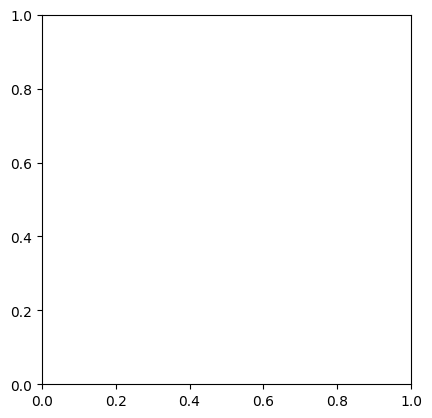

In [10]:
import matplotlib.pyplot as plt
plt.imshow(arr_image_ct, cmap='gray')

---
**Question 1.** Quel est le problème et comment le résoudre ?

---

En sélectionnant un plan de coupe particulier puisque que la fonction `imshow` ne sait qu'afficher une image 2D...

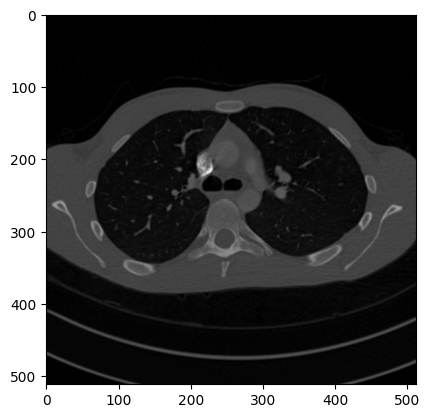

In [11]:
plt.imshow(arr_image_ct[415,:,:], cmap='gray')

On peut ruser en créant une fonction qui permet l'affichage d'une image 3D selon ses 3 plans de coupe

In [12]:
# Home-made function to show a 3D image in three views
def show_image(arr,sx,sy,sz,color):
    fig, ax = plt.subplots(1,3, figsize=(10, 10))
    ax[0].imshow(arr[sz,:,:], cmap=str(color)) #
    ax[0].set_title("Vue axiale (transverse)")
    ax[1].imshow(arr[:,sy,:], cmap=str(color), origin='lower')
    ax[1].set_title("Vue coronale (frontale)")
    ax[2].imshow(arr[:,:,sx], cmap=str(color), origin='lower')
    ax[2].set_title("Vue sagittale")

interactive(children=(IntSlider(value=255, description='sx', max=511), IntSlider(value=255, description='sy', …

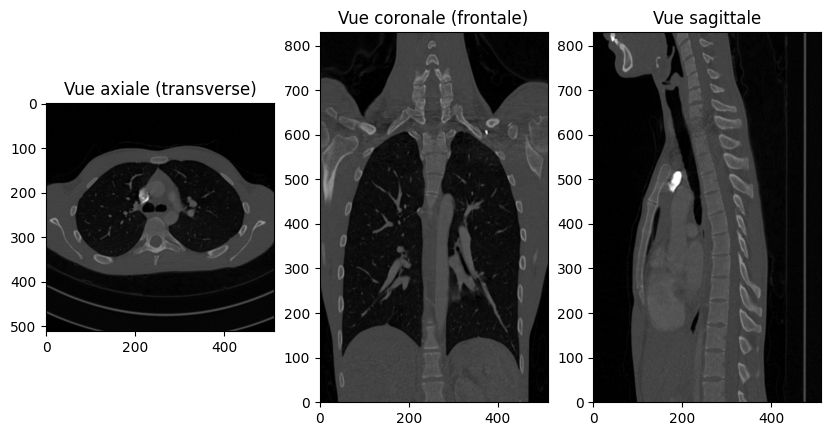

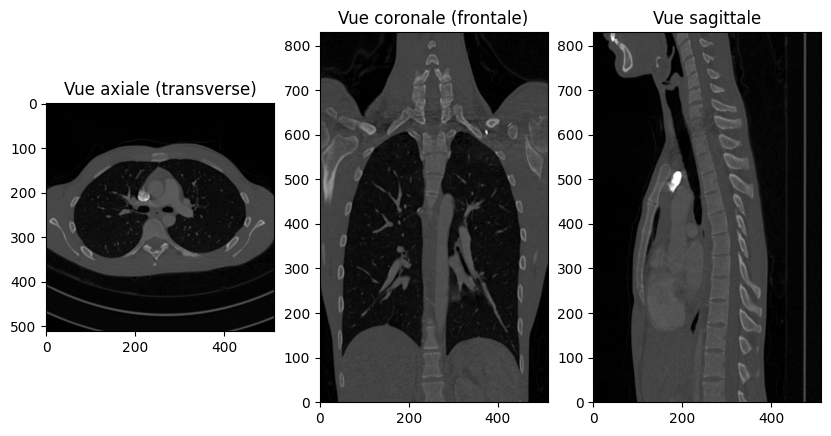

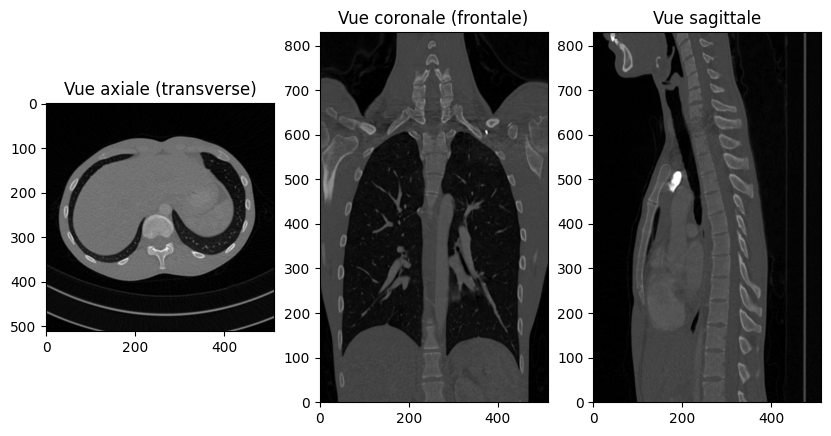

In [13]:
# View CT
from ipywidgets import interact, interactive, fixed
interact(show_image, arr=fixed(arr_image_ct), sx=(0,image_ct.GetSize()[0]-1), sy=(0,image_ct.GetSize()[1]-1), sz=(0,image_ct.GetSize()[2]-1),color='gray');

#### 1.2.2 De Numpy à SimpleITK

On utilise la fonction suivante :

- `GetImageFromArray()`: Get a SimpleITK Image from a numpy array. If isVector is True, then the Image will have a Vector pixel type, and the last dimension of the array will be considered the component index. By default when isVector is None, 4D images are automatically considered 3D vector images.

N'oubliez pas de définir l'origine de l'image (`SetOrigin([x,y])`), sa résolution (`SetSpacing([sx,sy,sz])`) et potentiellement sa matrice des directions (`SetDirection()`). Les valeurs par défaut peuvent ne pas correspondre aux dimensions physiques de votre image.

Le plus simple, c'est d'appliquer la méthode `CopyInformation()` à l'image que l'on souhaite enregistrer avec pour paramètre le nom de l'image de référence dont on récupère les informations.

Exemple : <code>new_img.CopyInformation(original_img)</code>   


In [14]:
import numpy as np

arr = np.zeros((10,20,3))
print('Dimensions du tableau NumPy = ',arr.shape)

# If this is supposed to be a 3D gray scale image [x=3, y=20, z=10]
img = sitk.GetImageFromArray(arr)
print("Taille de l'image 3D en niveaux de gris après conversion SimpleITK =",img.GetSize())
print("Nombre de composantes par pixel de cette image après conversion SimpleITK =",img.GetNumberOfComponentsPerPixel())

# If this is supposed to be a 2D color image [x=20,y=10]
img = sitk.GetImageFromArray(arr, isVector=True)
print("Taille de l'image 2D en couleurs après conversion SimpleITK =",img.GetSize())
print("Nombre de composantes par pixel de cette image après conversion SimpleITK =",img.GetNumberOfComponentsPerPixel())

Dimensions du tableau NumPy =  (10, 20, 3)
Taille de l'image 3D en niveaux de gris après conversion SimpleITK = (3, 20, 10)
Nombre de composantes par pixel de cette image après conversion SimpleITK = 1
Taille de l'image 2D en couleurs après conversion SimpleITK = (20, 10)
Nombre de composantes par pixel de cette image après conversion SimpleITK = 3


### 1.3 Opérations basiques sur les images

On peut profiter des fonctionnalités NumPy sur les tableaux pour réaliser des opérations telles que :
1. la symétrie
2. le sous-échantillonnage
3. le recadrage

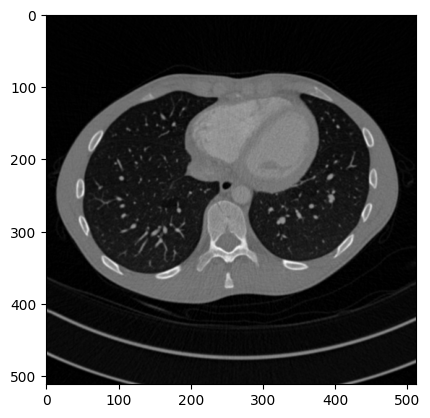

In [15]:
arr_200 = arr_image_ct[200,:,:] # Ici on sélectionne le plan de coupe d'indice 200
plt.imshow(arr_200,cmap='gray')

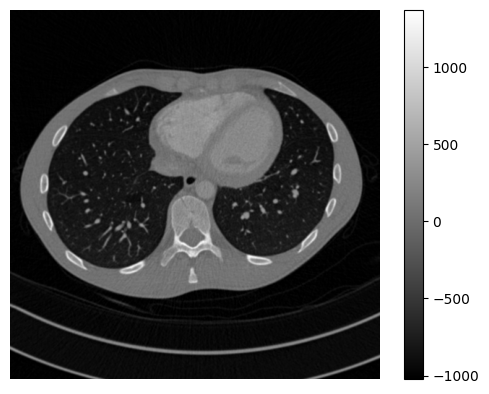

In [16]:
# Suppression des axes et ajout d'une colorbar
plt.imshow(arr_200,cmap='gray')
plt.axis('off')
plt.colorbar()

#### 1.3.1 Symétrie

Text(0.5, 1.0, 'Symétrie miroir horizontale')

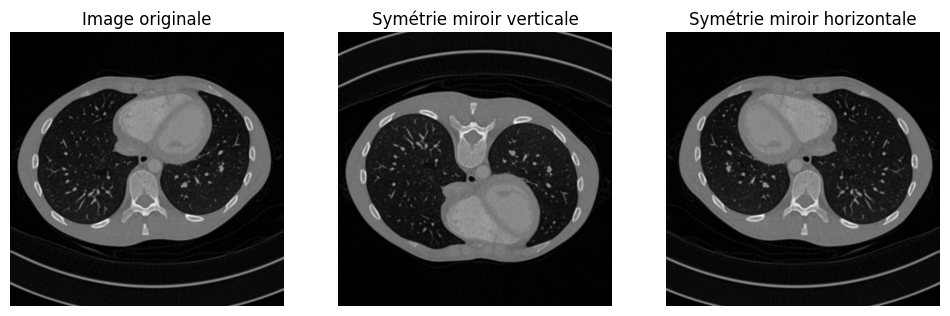

In [17]:
# Vertical flip (reverse the y axis)
arr_200_vflip = arr_200[::-1,::] # [start:stop:step]
# By default, start is 0 (first element), stop is last element index and step is 1.
# A negative step can be used to obtain a reversed list. Negative step changes a way, slice notation works.
# It makes the slice be built from the tail of the list.
# So, it goes from the last element to the first element.
# This way, we reverse the array order along y

# Horizontal flip (reverse the x axis)
arr_200_hflip = arr_200[::,::-1]

plt.subplots(1, 3, figsize=(12, 6))
plt.subplot(1,3,1)
plt.imshow(arr_200,cmap='gray')
plt.axis('off')
plt.title('Image originale')
plt.subplot(1,3,2)
plt.imshow(arr_200_vflip,cmap='gray')
plt.axis('off')
plt.title('Symétrie miroir verticale')
plt.subplot(1,3,3)
plt.imshow(arr_200_hflip,cmap='gray')
plt.axis('off')
plt.title('Symétrie miroir horizontale')

#### 1.3.2 Sous-échantillonnage

Text(0.5, 1.0, 'Image sous-échantillonnée')

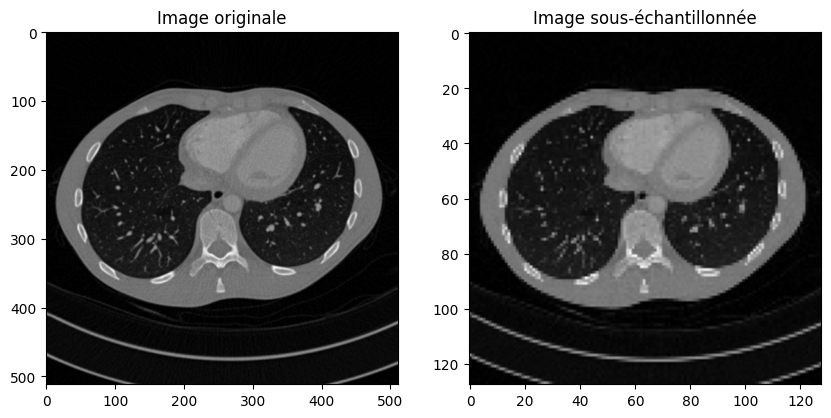

In [18]:
# Subsampling
# Here, we keep only every 4-th element of the array
arr_200_subsample = arr_200[::4,::4]

plt.subplots(1, 2, figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(arr_200,cmap='gray')
plt.title('Image originale')
#plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(arr_200_subsample,cmap='gray')
plt.title('Image sous-échantillonnée')
#plt.axis('off');

#### 1.3.3 Recadrage

Text(0.5, 1.0, 'Image du coeur')

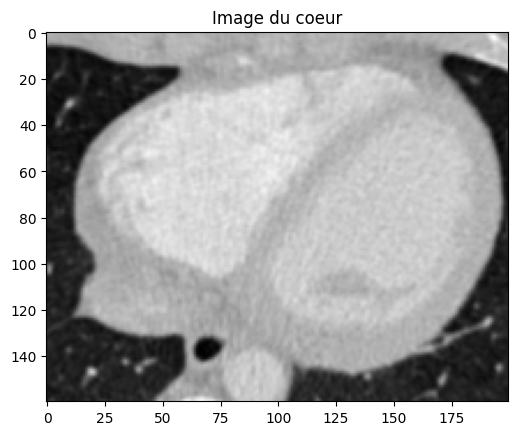

In [19]:
# Crop the original CT image so as to extract the heart
heart = arr_200[100:260,180:380]
plt.imshow(heart,cmap='gray')
plt.title('Image du coeur')

## Exercice 1
---

* Charger l'image `1-PT.nii` contenue dans le sous-dossier `data`
* Afficher les dimensions de cette image
* Convertir l'image en un tableau (array) NumPy de la même taille
* Afficher les dimensions de ce tableau
* Identifier un plan de coupe sur lequel on voit nettement la tumeur qui se trouve dans le poumon
* Rogner l'image afin d'effecteur un zoom sur cette tumeur et afficher le résultat


In [20]:
image_pet = sitk.ReadImage('./data/1-PT.nii')
print("Taille de l'image CT (SimpleITK) = ", image_pet.GetSize())

Taille de l'image CT (SimpleITK) =  (200, 200, 543)


In [21]:
arr_image_pet = sitk.GetArrayFromImage(image_pet)
print("Taille du tableau (NumPy) correspondant = ", arr_image_pet.shape)

Taille du tableau (NumPy) correspondant =  (543, 200, 200)


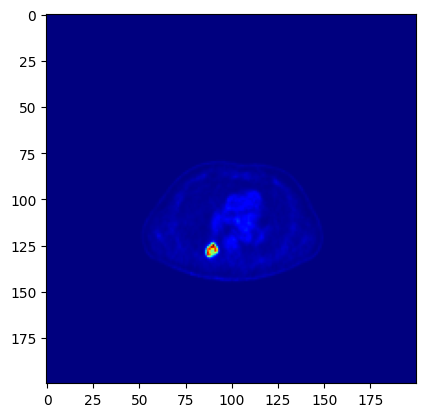

In [22]:
plan = 337
tumeur = arr_image_pet[plan,:,:]
plt.imshow(tumeur,cmap='jet')

## <a name="part2"></a>2. Afficher et manipuler des images au format DICOM

L'extension .dcm désigne un fichier DICOM.

Dans un fichier DICOM, les données sont organisées de façon séquentielle en commencant par une **entête** (1%), suivie des **données brutes** de l'image (99%).

<center>
<img width=500 src="https://github.com/marsvn/PythonM2-jour2/blob/main/data/dicom2.png?raw=1">
</center>

L'entête DICOM ou *DICOM Tag Header* contient un ensemble d'informations spécifiques appelées **meta-données**, renseignées par des attributs aussi appelés étiquettes ou *tags* en anglais.

* Attributs constructeur
* Attributs patient (état civil, âge, poids etc.)
* Attributs examen (région explorée, technique d'imagerie utilisée, date d'acquisition, praticien etc.)

Lire l'entête DICOM peut s'avérer utile pour :
* Contrôler l'origine d'une image
* Vérifier des paramètres d'acquisition (traceur, kV, champ magnétique)
* Extraire des données pour la recherche (traitement d'images)

Les données brutes de l'image peuvent être :
* Non comprimées (RAW)
* ...ou comprimées (24 types différents)
    * RLE
    * JPEG Lossless (1:2 sans perte)
    * JPEG lossy (1:20 avec perte)
    * JPEG2000...

A l'issue d'un examen médical, un dossier parfois nommé *DICOMDIR* contient la liste des fichiers générés (images, compressées ou non, parfois des vidéos voire des compte-rendus). Il est possible de visualiser la totalité d'un examen dans l'ordre chronologique et par série (par exemple, coupes avant injection, coupes après injection, reconstruction selon un autre plan de coupe etc.).

<center>
<img width=600 src="https://github.com/marsvn/PythonM2-jour2/blob/main/data/dicomstructure.jpg?raw=1">
</center>
    
Les particularités des fichiers DICOM ainsi que les besoins spécifiques des médecins qui les utilisent justifient l'existence de logiciels dédiés pour les manipuler mais aussi pour les classer et pour les partager en réseau (PACS - Picture Archiving and Communication Systems).

Les consoles d'acquisition et de nombreux logiciels libres de visualisation et de traitement d'images permettent aujourd'hui la lecture des entêtes et des images DICOM. Le site de la NEMA en propose une large sélection, régulièrement mise à jour (http://idoimaging.com/programs).

## Préambule

Il peut être parfois utile de commencer par créer une cellule permettant de définir l'environnement de travail nécessaire à l'exécution du notebook : import des bibliothèques et des fonctions utiles, définition des répertoires (répertoire courant, données d'entrée et de sortie) etc.

In [23]:
# Import des librairies de base
import numpy as np
import matplotlib.pyplot as plt
import os

# Import de la librairie SimpleITK
import SimpleITK as sitk

# Import some interactive IPython widgets
# The interact function (ipywidgets.interact) automatically creates user interface (UI) controls for exploring code and data interactively.
from ipywidgets import interact, interactive, fixed

# Definition du répertoire de travail courant

# Definition du répertoire dans lequel on stockera les données de sortie
OUTPUT_DIR = '/content/PythonM2-jour2/output'
# S'il n'existe pas, on le crée
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## Première méthode pour charger des séries d'images DICOM

Dans les cellules suivantes, nous allons procéder à la **lecture** de séries d'images DICOM obtenues après une acquisition TEP/TDM, à leur **affichage** et à leur **sauvegarde** sous la forme de fichiers image 3D au format mhd/mha ou nii. Dans notre exemple, les deux séries d'images sont stockées dans un seul et même répertoire (mais ce n'est pas toujours le cas).

### 1. Lecture des séries d'images DICOM TEP et TDM

#### 1.1 Identification des numéros de séries corresondant aux données TEP et TDM

In [ ]:
# Define DICOM data directory
data_dcm_directory = './data/patient2/'
print("Path to DICOM data directory:",data_dcm_directory)

# Provide a file name that belongs to the DICOM CT series you want to read
#!ls './data/patient2/'
file_name_ct= os.path.join(data_dcm_directory,'Patient2.CT._.4.1.2019.11.21.11.52.34.596.71223801.dcm')

# Read the file's meta-information without reading bulk pixel data
file_reader_ct=sitk.ImageFileReader()
file_reader_ct.SetFileName(file_name_ct)
file_reader_ct.ReadImageInformation()

# Get the sorted file names, open all files in the directory and read the meta-information without reading the bulk pixel data
series_ID_ct=file_reader_ct.GetMetaData('0020|000e')
sorted_file_names_ct=sitk.ImageSeriesReader.GetGDCMSeriesFileNames(data_dcm_directory,series_ID_ct)
print("Series ID corresponding to CT data:",series_ID_ct)

# Provide a file name that belongs to the DICOM PET series you want to read
file_name_pet=os.path.join(data_dcm_directory,'Patient2.PT._.3.144.2019.11.21.11.52.34.596.71220765.dcm')
# Read the file's meta-information without reading bulk pixel data
file_reader_pet=sitk.ImageFileReader()
file_reader_pet.SetFileName(file_name_pet)
file_reader_pet.ReadImageInformation()

# Get the sorted file names, open all files in the directory and read the meta-information without reading the bulk pixel data
series_ID_pet=file_reader_pet.GetMetaData('0020|000e')
sorted_file_names_pet=sitk.ImageSeriesReader.GetGDCMSeriesFileNames(data_dcm_directory,series_ID_pet)
print("Series ID corresponding to PET data:",series_ID_pet)

#### 1.2 Lecture des images et de leurs attributs

In [ ]:
# Read DICOM CT and PET images and convert them to NumPy arrays
# Access to their attributes (size, origin and spacing)
img_ct=sitk.ReadImage(sorted_file_names_ct)
print('Image CT size: ', img_ct.GetSize())
print('Image CT origin: ', img_ct.GetOrigin())
print('Image CT spacing: ', img_ct.GetSpacing(),'\n')

img_pet=sitk.ReadImage(sorted_file_names_pet)
print('Image PET size: ', img_pet.GetSize())
print('Image PET origin: ', img_pet.GetOrigin())
print('Image PET spacing: ', img_pet.GetSpacing())

### 2. Affichage des images DICOM

#### 2.1 Utilisation de Matplotlib et de la fonction interact

Comme dans le notebook précédent, on va d'abord convertir les images qui sont toujours des objets SimpleITK en arrays NumPy.

In [ ]:
nimg_ct = sitk.GetArrayFromImage(img_ct)
print(nimg_ct.shape)
nimg_pet = sitk.GetArrayFromImage(img_pet)
print(nimg_pet.shape)

Ci-dessous, on crée une fonction permettant l'affichage d'une image 3D selon ses 3 plans de coupe

In [ ]:
# Home-made function to show a 3D image in three views
def show_image(arr,sx,sy,sz,color):
    fig, ax = plt.subplots(1,3, figsize=(10, 10))
    ax[0].imshow(arr[sz,:,:], cmap=str(color)) #
    ax[0].set_title("Vue axiale (transverse)")
    ax[1].imshow(arr[:,sy,:], cmap=str(color), origin='lower')
    ax[1].set_title("Vue coronale (frontale)")
    ax[2].imshow(arr[:,:,sx], cmap=str(color), origin='lower')
    ax[2].set_title("Vue sagittale")

In [ ]:
# View CT
interact(show_image, arr=fixed(nimg_ct), sx=(0,img_ct.GetSize()[0]-1), sy=(0,img_ct.GetSize()[1]-1), sz=(0,img_ct.GetSize()[2]-1),color='gray');

In [ ]:
# View PET
interact(show_image, arr=fixed(nimg_pet), sx=(0,img_pet.GetSize()[0]-1), sy=(0,img_pet.GetSize()[1]-1), sz=(0,img_pet.GetSize()[2]-1),color='jet');

Comme vous pouvez le constater, l'utilisation de la fonction `imshow` de Matplotlib (très efficace par ailleurs) devient problématique dès lors qu'on travaille avec des images qui ont une haute dynamique ou qui ont un voxel size non isotrope, ce qui est le cas de la plupart des images médicales 3D. L'image apparait ainsi déformée à l'affichage.

Dans les cellules suivantes, on affiche les deux modalités d'imagerie superposées l'une sur l'autre.

In [ ]:
# Home-made function to overlay two 3D images from different modality imaging (here, CT and PET)
def show_fusion(arr, nslice, opacity=0.7 ):
    plt.imshow(nimg_pet[nslice,:,:], cmap=plt.cm.jet)
    plt.colorbar()
    a = arr[nslice,:,:]
    plt.imshow(a, alpha=opacity, cmap=plt.cm.gray)
    plt.colorbar()
    #plt.savefig('fusion.png',dpi=300,transparent=True,bbox_inches="tight")

In [ ]:
# View overlaid CT and PET images
interact(show_fusion, arr=fixed(nimg_ct), nslice=(0,len(nimg_pet)-1), opacity=(0,1,0.1));

----
**Question 2.** Quel est le problème et comment le résoudre ?

----

In [ ]:
# Assuming these two images are already registered, we can resample the CT volume according to the origin, spacing and dimensions of the PET volume.
# Hence, we preserve their individual locations as each has a different origin, spacing and orientation in the same space.
print("Transformation appliquée :",sitk.Transform())
img_resampled_ct = sitk.Resample(img_ct, img_pet, sitk.Transform(), sitk.sitkLinear, 0)
print("On peut vérifer les dimensions de l'image CT après rééchantillonnage\n")
print("Taille de l'image CT après rééchantillonnage : ", img_resampled_ct.GetSize())
print("Taille des pixels de l'image CT après rééchantillonnage :" , img_resampled_ct.GetSpacing())
nimg_resampled_ct = sitk.GetArrayFromImage(img_resampled_ct)
output_file_name_3D_resampled_ct = os.path.join(OUTPUT_DIR, '3DImageResampledCT.nii')
sitk.WriteImage(img_resampled_ct, output_file_name_3D_resampled_ct)

In [ ]:
# View overlaid resampled CT and PET images
interact(show_fusion, arr=fixed(nimg_resampled_ct), nslice=(0,len(nimg_pet)-1), opacity=(0,1,0.1));

### 2.2 Sauvegarder les series d'images DICOM en images directement 3D

In [ ]:
# Read the bulk pixel data and write them as a single 3D nii or mha file
output_file_name_3D_ct = os.path.join(OUTPUT_DIR, '3DImageCT.nii') #'3DImageCT.mha'
sitk.WriteImage(img_ct, output_file_name_3D_ct)
output_file_name_3D_pet = os.path.join(OUTPUT_DIR, '3DImagePET.nii') #'3DImagePET.mha'
sitk.WriteImage(img_pet, output_file_name_3D_pet)

### 2.3 Utilisation de SimpleITK

Quand on travaille avec des images médicales, il est recommandé de les visualiser à l'aide de logiciels dédiés comme par exemple [3D Slicer](https://www.slicer.org/) ou [ITK-SNAP](http://www.itksnap.org/pmwiki/pmwiki.php), tous deux téléchargeables gratuitement.

Si vous voulez malgré tout visualiser vos images avec Python, utilisez la fonction `Show`.

La fonction `Show` permet d'afficher l'image passée en paramètre à la fonction. Par défaut, le système cherchera à utiliser le logiciel *[ImageJ](http://imagej.nih.gov/ij/)* présent sur votre système.

In [ ]:
sitk.Show?

In [ ]:
%env SITK_SHOW_COMMAND "C:\Program Files\Slicer 4.10.2\Slicer"

try:
    sitk.Show(img_pet)
except RuntimeError:
    print('SimpleITK Show method could not find the viewer (ImageJ not installed or ' +
          'environment variable pointing to non existant viewer).')

Il est possible de changer ce comportement par défaut en assignant la variable d'environnement `SITK_SHOW_COMMAND` sur une autre application permettant de visualiser les images ([`ITK-SNAP`](http://www.itksnap.org), [`3D Slicer`](www.slicer.org)).

In [ ]:
%env SITK_SHOW_COMMAND "/usr/local/itksnap-3.8.0-20190612-Linux-gcc64/bin/itksnap"

pet_image = sitk.ReadImage(output_file_name_3D_pet)
try:
    sitk.Show(pet_image)
except RuntimeError:
    print('SimpleITK Show method could not find the viewer (ITK-SNAP not installed or ' +
          'environment variable pointing to non existant viewer).')

In [ ]:
%env SITK_SHOW_COMMAND "/usr/local/bin/Slicer"

pet_image = sitk.ReadImage(output_file_name_3D_pet)
try:
    sitk.Show(pet_image)
except RuntimeError:
    print('SimpleITK Show method could not find the viewer (Slicer not installed or ' +
          'environment variable pointing to non existant viewer).')

## Deuxième méthode pour charger des séries d'images DICOM

Dans les cellules suivantes, vous allez découvrir comment avec **une seule boucle**, on peut **lire**, **afficher** et **sauvegarder** des séries d'images DICOM (à réutiliser sans modération)

In [ ]:
data_dcm_directory = './data/patient2/'
print("Path to DICOM data directory:",data_dcm_directory)

# Directory contains multiple DICOM studies/series, store in dictionary with key being the series ID
reader = sitk.ImageSeriesReader()
series_file_names = {}
series_IDs = reader.GetGDCMSeriesIDs(data_dcm_directory)

In [ ]:
# Display both modality imaging side by side
plt.subplots(1,2,figsize=(10,5))
# Check that we have at least one series
if series_IDs:
    print("Il y a " + str(len(series_IDs)) + " serie(s) dans le dossier " + data_dcm_directory+'\n')
    for i, series in enumerate(series_IDs):
        print("Serie numéro", i+1)
        print('Series ID:', series)
        series_file_names[series] = reader.GetGDCMSeriesFileNames(data_dcm_directory, series)
        reader.SetFileNames(series_file_names[series])
        reader.MetaDataDictionaryArrayUpdateOn()
        reader.LoadPrivateTagsOn()
        img = reader.Execute()
        modality=reader.GetMetaData(2,'0008|0060')
        print('Modality:',modality)
        sitk.WriteImage(img,os.path.join(OUTPUT_DIR,str(modality)+".nii"))
        print("-> Sauvegarde de l'image "+str(modality)+".nii "+"-> OK\n")
        # Display the image slice from the middle of the stack, z axis
        z = int(img.GetDepth()/2)
        plt.subplot(1,2,i+1)
        if modality == 'CT':
            plt.imshow(sitk.GetArrayViewFromImage(img)[z,:,:], cmap='gray')
        if modality == 'PT':
            plt.imshow(sitk.GetArrayViewFromImage(img)[z,:,:], cmap='jet')
        plt.title('Modality: ' + modality)
        plt.axis('off')
        plt.colorbar(shrink=0.7)
else:
    print('Data directory does not contain any DICOM series.')

In [ ]:
## <a name="part3"></a>3. Lecture des en-têtes DICOM à l'aide de la librairie pydicom

La librairie [pydicom](https://pydicom.github.io/) offre de nombreuses fonctionnalités pour manipuler assez simplement des fichiers DICOM en Python, en particulier leurs meta-données.

Dans le notebook précédent, nous avons ouvert et analysé le fichier image intitulé `PosteriorStatic001_DS.dcm`. L'extension de ce fichier nous indique qu'il s'agit d'une image DICOM et son nom qu'il s'agit certainement d'une image de scintigraphie. Nous allons vérifier cela et plus généralement nous intéresser aux meta-données de cette image en l'ouvrant cette fois-ci non plus avec `SimpleITK` mais avec avec le module `pydicom`.

Importez le module `pydicom` pour pouvoir l'utiliser dans votre programme.

In [ ]:
import pydicom as dcm

La commande suivante execute la fonction `read_file` du module pydicom qu'on a renommé dcm.

In [ ]:
dataset = dcm.read_file('./data/rein/PosteriorStatic001_DS.dcm')

En tapant `dataset`, on affiche l'ensemble des meta-données du fichier DICOM.

In [ ]:
dataset

* Les meta-données sont organisées en plusieurs **groupes d'informations**
* Chaque groupe d'informations contient plusieurs **éléments** ou **attributs**

L'ensemble de ces meta-données constitue un dictionnaire de données DICOM.

<center>
<img src="https://github.com/marsvn/PythonM2-jour2/blob/main/data/dicomstructure.png?raw=1">
</center>

<center>
<img src="https://github.com/marsvn/PythonM2-jour2/blob/main/data/dicom-table.png?raw=1">
</center>



Choisissons un attribut particulier

In [ ]:
dataset[0x008,0x060]

La commande précédente affiche la ligne correspondant à l'élément ou attribut ou *tag element* (0008, 0060).

Le format de cette ligne est le suivant :

- **(0008, 0060)** : numéro de l'attribut (*tag number*), codé en hexadecimal suivant (numéro du groupe, numéro de l'attribut)

- **Modality** : nom de cet attribut, s'il est connu

- **CS**: valeur de représentation de l'attribut, si elle est connue

- **'NM'**: valeur de l'attribut considéré


Pour accéder à un attribut spécifique, on peut utiliser son numéro (dans l'exemple ci-dessus, c'est (0x008,0x060)) ou le mot-clé DICOM correspondant (dans l'exemple ci-dessus, c'est `Modality`).

Le mot-clé est généralement le même que le nom de l'élément sans espace. Quelques exceptions néanmoins comme `(0010,0010) Patient’s Name` dont le mot-clé correspondant est `PatientName`.

Une liste de tous les mots-clé peut être consultée [ici](http://dicom.nema.org/medical/dicom/current/output/chtml/part06/chapter_6.html).

In [ ]:
dataset['Modality']

In [ ]:
dataset[0x008,0x060].value

In [ ]:
dataset.Modality

In [ ]:
print("Patient's Name:", dataset.PatientName)
print('Patient ID:', dataset[0x10,0x20].value)

La commande suivante permet de trier le dataset, en affichant uniquement l'ensemble des éléments du groupe d'informations `0010`

In [ ]:
dataset.group_dataset(0x0010)

La commande suivante permet d'afficher la valeur du tag number associé à l'attribut `Patient ID`.

In [ ]:
print(dataset.data_element("PatientID").tag)

Vérifions

In [ ]:
print(dataset[0x0010,0x0020].value)

La fonction `dataset.dir()` permet de retrouver tous les mots-clés contenant une chaîne de caractère donnée.

In [ ]:
dataset.dir("UID")

In [ ]:
liste = dataset.dir('patien')
print(liste)

In [ ]:
for i in liste:
#    print(i)
    print(i,"=>",dataset[i].value)

## Utilisation de pydicom conjointement avec Matplotlib

L'utilisation de la bibliothèque pydicom est principalement dédiée à l'exploration et la manipulation des meta-données DICOM.

Il peut être utile de visualiser les données image.

Pour cela, plusieurs options :

* Utiliser un logiciel capable de lire le DICOM (3D Slicer, ImageJ, ITK-SNAP)
* Utiliser pydicom avec Matplotlib

L'attribut `(7FE0,0010) Pixel Data` donne accès aux données images brutes d'un fichier DICOM.

L'attribut `Dataset.pixel_array` retourne directement un tableau Numpy.


In [ ]:
pixel_bytes = dataset.PixelData

In [ ]:
pixel_bytes

In [ ]:
arr = dataset.pixel_array

In [ ]:
arr

In [ ]:
print(arr.shape, arr.size)

Taille de l'image : 128 x 128 (16394 pixels)

De cette façon, Matplotlib peut accéder à l'information contenue dans cette image 2D et l'afficher.

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(arr, cmap='jet')
plt.colorbar()

## Modification de fichiers par lot

On peut aussi utiliser pydicom pour modififier certains tags d'une série de fichiers DICOM.

Une utilisation potentielle de cette fonctionnalité est l'**anonymisation** de fichiers.

Les fichiers présents dans le répertoire `data/patient2` sont déjà anonymisés mais on va à nouveau modifier l'attribut `PatientName` comme on pourrait le faire pour anonymiser ces fichiers.

In [ ]:
import pydicom as dcm
from pathlib import Path

# La syntaxe suivante permet de rechercher une chaîne de caractères précise dans un liste de fichiers
dcm_files = Path('./data/patient2/').rglob('*.dcm')
dcm_files_CT = Path('./data/patient2/').rglob('*CT*.dcm')
dcm_files_PT = Path('./data/patient2/').rglob('*PT*.dcm')

# La fonction len() affiche la longueur d'une liste (donc ici le nombre de fichiers)
print('Nombre de fichiers total dans la série :',len(list(dcm_files)))
print('Nombre de fichiers TDM dans la serie :',len(list(dcm_files_CT)))
print('Nombre de fichiers TEP dans la serie :',len(list(dcm_files_PT)))

In [ ]:
# Liste contenant tous les fichiers DICOM du dossier patient2
dcm_files = Path('./data/patient2/').rglob('*.dcm')

# Création du nouveau répertoire patient2_anonymised s'il n'existe pas (s'il existe, on ne fait rien)
output_dir = Path('./data/patient2_anonymised/')
output_dir.mkdir(exist_ok=True)

# Boucle sur l'ensemble des fichiers DICOM du répertoire patient2
for file_dcm in dcm_files:
    # Lecture de l'entête DICOM de chaque fichier
    ds = dcm.read_file(str(file_dcm))
    #print(ds.PatientName)
    # Les images DICOM de sortie (après anonymisation) auront le même nom
    out_file = file_dcm.name
    # Modification de l'attribut PatientName : patient2 --> M2
    ds.PatientName = "M2"
    # Réécriture des nouveaux fichiers DICOM et stockage dans le dossier patient2_anonymised
    dcm.write_file(str(output_dir / out_file), ds)

In [ ]:
# On vérifie que l'attribut PatientName a bien été modifié
newdcm_files = Path('./data/patient2_anonymised/').rglob('*.dcm')
# Nom du patient après anonymisation
print("Vérification --> nom du patient après anonymisation :",dcm.read_file(str(list(newdcm_files)[0])).PatientName)

## Exercice 1
---

1. Retrouver les dimensions de l'image `PosteriorStatic001_DS.dcm` et sa résolution
2. Retrouver quel était le radiopharmaceutique injecté

In [ ]:
print(dataset.Rows, dataset.Columns)
print(dataset.PixelSpacing)

In [ ]:
print(dataset.RadiopharmaceuticalInformationSequence)
print(dataset.data_element("RadiopharmaceuticalInformationSequence").tag)

In [ ]:
print(dataset[0x0054,0x0016][0][0x0054,0x0300][0][0x0008,0x0104].value)

## Exercice 2
---

Objectifs de l'exercice :

1. Lecture d'images TEP et CT préalablement sauvegardées au format DICOM
2. Identification de la modalité TEP
3. Ajout d'une étape de calcul du facteur de conversion en unités SUV
4. Sauvegarde du fichier SUV

Pour cela, il est nécessaire d'accéder aux valeurs des attributs DICOM suivants :

* `Series Time`: Time the series started. Series Date and Series Time are used as the reference time for all PET Image Attributes that are temporally related, including activity measurements.
* `Radiopharmaceutical Start Time`: Time of start of administration. The actual time of radiopharmaceutical administration to the patient for imaging purposes, using the same time base as Series Time. Example: "070907.0705" represents a time of 7 hours, 9 minutes and 7.0705 seconds.
* `Radionuclide Total Dose`: The radiopharmaceutical dose administered to the patient measured in Becquerels (Bq) at the Radiopharmaceutical Start Time.
* `Radionuclide Half Life`: The radionuclide half life, in seconds, to be used in the correction of this image.
* `Patient's Weight`: Weight of the Patient, in kilograms.

Le site internet https://dicom.innolitics.com/ciods/pet-image regroupe l'ensemble des attributs DICOM relatif à la modalité d'imagerie TEP et renseigne les valeurs de tag number correspondants.

## Rappels sur le SUV (Standardized Uptake Value)

La valeur de fixation normalisée (SUV en anglais pour Standardized Uptake Value) est l'index semi-quantitatif le plus communément utilisé en routine clinique pour caractériser la fixation du FDG en TEP.

Dans  sa  définition  la  plus  classique,  le  SUV  se  calcule comme   le   rapport   de   la   concentration moyenne du radiotraceur dans   un   tissu   d’intérêt (en Bq/mL) à un instant donné à l'activité totale injectée au patient (en Bq), rapporté à son volume (en mL). En supposant que le patient a une masse volumique de 1 g/mL, la valeur du volume en mL est la même que celle de la masse en grammes.

Le SUV est calculé en pratique en rapportant l'activité injectée au poids du patient.

$$ SUV_{BW}=\frac{[^{18}F-FDG]}{\frac{A_{inj}(t_{acq})}{W}} $$

Bien sûr, il faut tenir compte dans la formule ci-dessus du délai de temps $\Delta t$ entre l'injection et l'acquisition.

$$ A_{inj_{c}}=A_{inj}(t_{acq})\times 2^{(\frac{-\Delta t}{T_{1/2}})} $$

Le SUV est donc une quantité sans dimension, dont l’usage fréquent est en particulier dû à la simplicité de sa méthode de calcul.
* Si le radiotraceur se répartissait uniformément dans tout l’organisme,   le   SUV   serait   identique   en   tout   point   de l’organisme  et  égal  à 1.Tout  écart  du  SUV à 1  traduit  une répartition non uniforme du radiotraceur dans le volume dans lequel il s’est distribué.
* Le pouvoir de normalisation du SUV facilite l’interprétation   semi-quantitative   des   images.   En   effet,   même   si   la normalisation sous-jacente au calcul du SUV est grossière, elle est   tout   de   même   largement   préférable   à l’absence   de normalisation.  
* L’expression  des  images  en  échelle  SUV  rend comparables des images acquises chez différents patients, et des images acquises chez un patient à différents stades de la prise en charge thérapeutique.
* La normalisation n’est certes pas parfaite mais elle réduit tout de même considérablement la variabilité inter-patients et inter-examens.  
* Le SUV reste donc un index simpliste pour caractériser le métabolisme du glucose.

NB. Cette formule suppose que les images TEP ont été préalablement calibrées (conversion des valeurs d'intensité en activité). On peut le vérifier à partir de l'attribut `Units`. Dans le cas contraire, il faudrait ajouter une conversion supplémentaire :

$PET_{activity} = PET_{raw} \times rescale\_ slope + rescale\_intercept$

$rescale\_ slope$ et $rescale\_intercept$ sont deux attributs DICOM accessibles (numéro (0028,1052) et (0028,1053) respectivement).

In [ ]:
import pydicom

data_dir = './data/patient4'

# Define current working directory
pwd_dir = os.getcwd()

# Define target directory
target_dir = os.path.join(pwd_dir,'output')

# Liste de toutes les series DICOM du répertoire source
series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(data_dir)

print("Il y a " + str(len(series_IDs)) + " série(s) présentes dans le répertoire " + data_dir)
print(*series_IDs,sep='\n')

for i, serie in enumerate(series_IDs): # Pour chaque série du répertoire source
    print(str(i) + "...",end = '')
    reader=sitk.ImageSeriesReader() # Définition du reader
    # Liste de tous les fichiers concernant la série considérée
    series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(data_dir,serie)
    reader.SetFileNames(series_file_names)
    # On va récupérer tous les tags DICOM de la série en lisant le 1er fichier de la série
    ds=pydicom.filereader.dcmread(series_file_names[0])
    print(ds[0x0008,0x0060].value,end='-')
    print(ds.Modality,end='|')
    print(ds.pixel_array.itemsize,end='|')
    print(ds.ProcedureCodeSequence[0][0x0008,0x0104].value,end='')
    if ds.pixel_array.itemsize!=1: # itemsize() function return the length of one array element in bytes (octets)
        try:                       # 1 <=> (u)int8 et 2 <=> (u)int16
            IMAGE=reader.Execute()
            chaine=str(i)+"-"+ds.Modality+".nii"
            sitk.WriteImage(IMAGE,os.path.join(target_dir,chaine))
            print("->"+chaine+"-> OK")
            #break
        except:
            print("->fail")
        verif_flag = True
        if ds.Modality == "PT":
            print("Unités des images :",ds[0x0054,0x1001])
            # Calcul du scale factor permettant la conversion Bq/mL<=>SUV
            RST = (ds[0x0054,0x0016][0][0x0018,0x1072].value) # RadiopharmaceuticalStartTime
            print(RST)
            RST = 3600 * int(RST[0:2]) + 60 * int(RST[2:4]) + float(RST[4:]) # string to numerical value in sec
            RTD = (ds[0x0054,0x0016][0][0x0018,0x1074].value) # RadionuclideTotalDose [Bq]
            RHL = (ds[0x0054,0x0016][0][0x0018,0x1075].value) # RadionuclideHalfLife [s]
            ST  = (ds[0x0008,0x0031].value)                   # SeriesTime
            ST  = 3600 * int(ST[0:2]) + 60 * int(ST[2:4]) + float(ST[4:]) # string to numerical value in sec
            PW  = (ds[0x0010,0x1030].value)                   # PatientWeight [kg]
            # RSD=(ds[0x0054,0x0016][0][0x0018,0x1078].value) #
            CD = RTD * pow(2,- (ST - RST) / RHL )             # CorrectedDose
            PET_SUV_ScaleFactor = PW * 1000 / CD # On multiplie par 1000 pour avoir le poids en g
            print("PET_SUV_ScaleFactor = ",PET_SUV_ScaleFactor)
            if verif_flag:
                print("Series Time       : " + (ds[0x0008,0x0031].value))
                print("Dose              : " + str(RTD) + " Bq ou " + str(RTD/1e6) + " MBq")
                print("Patient's Weight  : " + str(PW)+" kg")
                print("Half-life         : " + str(RHL) + " sec ou " + str(RHL/60) + " min")
                print("Start Time        : " + ds[0x0054,0x0016][0][0x0018,0x1072].value)
    else:
        print()
print("Fin")

In [ ]:
# Sauvegarde de l'image TEP après conversion en unités SUV
IMAGE = sitk.ReadImage(os.path.join(target_dir,'1-PT.nii'))
sitk.WriteImage(IMAGE*PET_SUV_ScaleFactor, os.path.join(target_dir,'1-PT_SUV.nii'))